INF2178
Assignment 4
Xuying Du

In [17]:
###import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, bartlett
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.power import TTestIndPower
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm

In [18]:
###Data loading and cleaning

# Load the dataset
data=pd.read_csv("./INF2178_A4_data.csv")

# Check for the number of missing values in each column
print(data.isnull().sum())

# Impute missing values in 'SES' and 'MMSE' with their median values
data['SES'].fillna(data['SES'].median(), inplace=True)
data['MMSE'].fillna(data['MMSE'].median(), inplace=True)

# Remove any rows that still have missing data if necessary
data.dropna(inplace=True)

# Convert categorical variables to appropriate data types
data['Group'] = data['Group'].astype('category')
data['M/F'] = data['M/F'].astype('category')
data['Hand'] = data['Hand'].astype('category')


Unnamed: 0     0
Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           15
MMSE           1
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64


       Unnamed: 0       Visit     MR Delay         Age        EDUC  \
count  294.000000  294.000000   294.000000  294.000000  294.000000   
mean   190.421769    1.489796   349.785714   76.411565   14.561224   
std    106.686740    0.500748   400.741520    7.607074    2.884818   
min      0.000000    1.000000     0.000000   60.000000    6.000000   
25%     99.000000    1.000000     0.000000   71.000000   12.000000   
50%    195.500000    1.000000     0.000000   76.000000   14.500000   
75%    282.750000    2.000000   671.500000   81.000000   16.000000   
max    371.000000    2.000000  1707.000000   98.000000   23.000000   

              SES        MMSE         CDR         eTIV        nWBV         ASF  
count  294.000000  294.000000  294.000000   294.000000  294.000000  294.000000  
mean     2.465986   27.265306    0.301020  1478.853741    0.731381    1.203109  
std      1.104072    3.409136    0.381347   176.559755    0.037373    0.139365  
min      1.000000   15.000000    0.000000  11

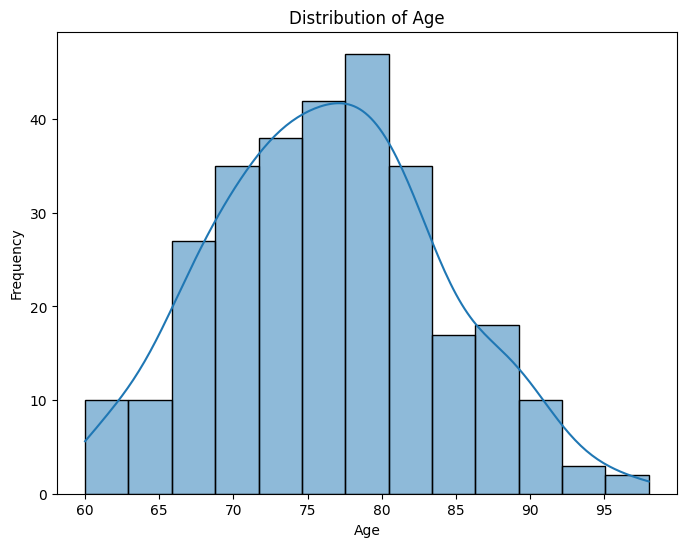

In [19]:
###Exploratory Data Analysis (EDA)

# Descriptive statistics
print(data.describe())

# Visualize the distribution of age
plt.figure(figsize=(8, 6))
sns.histplot(data['Age'], kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [20]:
data.Hand.value_counts()

R    294
Name: Hand, dtype: int64

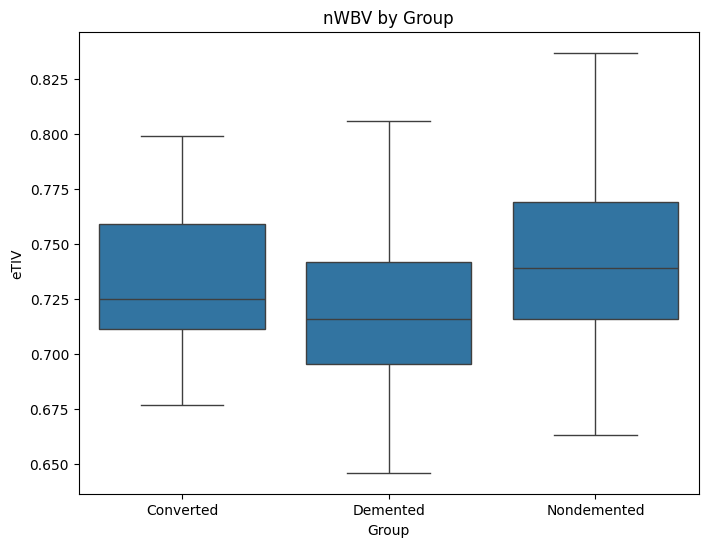

In [21]:
# Compare eTIV across Groups
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='nWBV', data=data)
plt.title('nWBV by Group')
plt.xlabel('Group')
plt.ylabel('eTIV')
plt.show()

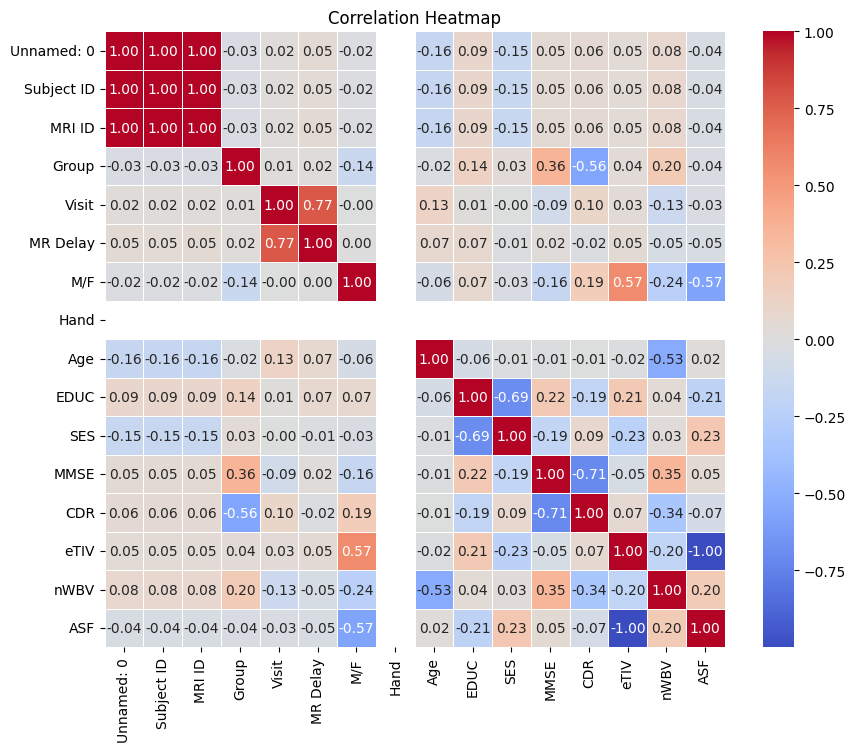

R    294
Name: Hand, dtype: int64

In [22]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# creat a copy for encoding
df_encoded = data.copy()
categorical_vars=df_encoded.columns
# Perform label encoding on categorical variables
label_encoder = LabelEncoder()
for var in categorical_vars:
    df_encoded[var] = label_encoder.fit_transform(df_encoded[var])

# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

#There is an issue here; the 'Hand' column is empty, and upon inspection of its classification result, it has only one category, making this column meaningless. Therefore, remove the 'Unnamed: 0' and 'Hand' columns, and then recreate the heatmap.
data.Hand.value_counts()

In [23]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  294 non-null    int64
 1   Subject ID  294 non-null    int64
 2   MRI ID      294 non-null    int64
 3   Group       294 non-null    int64
 4   Visit       294 non-null    int64
 5   MR Delay    294 non-null    int64
 6   M/F         294 non-null    int64
 7   Hand        294 non-null    int64
 8   Age         294 non-null    int64
 9   EDUC        294 non-null    int64
 10  SES         294 non-null    int64
 11  MMSE        294 non-null    int64
 12  CDR         294 non-null    int64
 13  eTIV        294 non-null    int64
 14  nWBV        294 non-null    int64
 15  ASF         294 non-null    int64
dtypes: int64(16)
memory usage: 36.9 KB


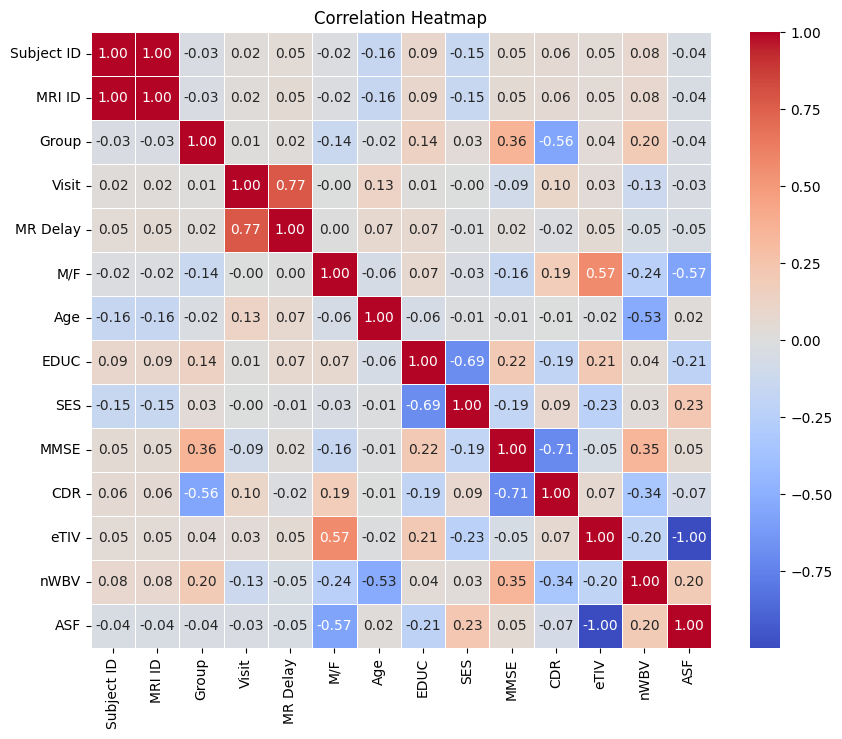

In [24]:
# creat a copy for encoding
df_encoded = data.copy()
df_encoded.drop(columns=['Unnamed: 0','Hand'],inplace=True)
categorical_vars=df_encoded.columns

# Perform label encoding on categorical variables
label_encoder = LabelEncoder()
for var in categorical_vars:
    df_encoded[var] = label_encoder.fit_transform(df_encoded[var])

# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

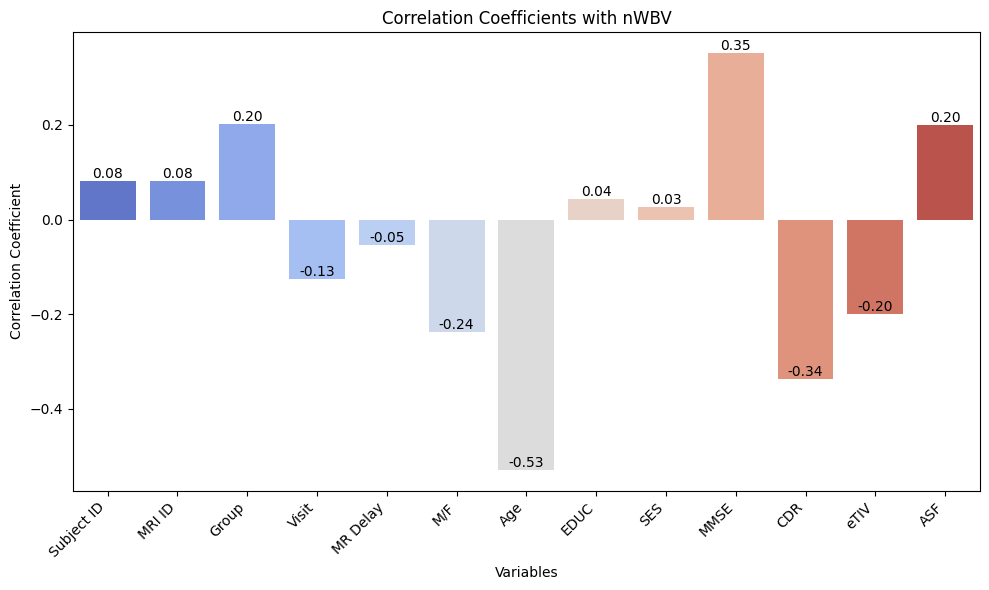

In [25]:
nwbv_corr = corr_matrix['nWBV'].drop('nWBV')
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=nwbv_corr.index, y=nwbv_corr.values, palette='coolwarm')

# Add data labels
for i, v in enumerate(nwbv_corr.values):
    barplot.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.title('Correlation Coefficients with nWBV')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
#Assumption tests

# Normality test using Shapiro-Wilk test for 'nWBV'
stat, p = shapiro(data['nWBV'])
print('Shapiro-Wilk Test for normality p-value:', p)

# If 'nWBV' is normally distributed, use Bartlett's test, otherwise use Levene's test
if p > 0.05:
    # Homogeneity of variances test using Bartlett's test for 'nWBV' across 'Group'
    stat, p = bartlett(data['nWBV'][data['Group'] == 'Nondemented'], data['nWBV'][data['Group'] == 'Demented'])
    print('Bartlett’s Test for equal variances p-value:', p)
else:
    # Homogeneity of variances test using Levene's test for 'nWBV' across 'Group'
    stat, p = levene(data['nWBV'][data['Group'] == 'Nondemented'], data['nWBV'][data['Group'] == 'Demented'])
    print('Levene’s Test for equal variances p-value:', p)


Shapiro-Wilk Test for normality p-value: 0.11870357394218445
Bartlett’s Test for equal variances p-value: 0.056611939421945014


In [27]:
#Mixed-Effects ANOVA Analysis
# Define and fit the first mixed-effects model with an interaction term
model1 = mixedlm("nWBV ~ Group", data, groups=data["Subject ID"])
result1 = model1.fit()
print(result1.summary())

# Define and fit the second mixed-effects model with an interaction term
model2 = mixedlm("nWBV ~ Group * Visit", data, groups=data["Subject ID"])
result2 = model2.fit()
print(result2.summary())

# Define and fit the third mixed-effects model
model3 = mixedlm("nWBV ~ Group * Visit * EDUC", data, groups=data["Subject ID"])
result3 = model3.fit()
print(result3.summary())


             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    nWBV    
No. Observations:    294        Method:                REML    
No. Groups:          150        Scale:                 0.0001  
Min. group size:     1          Log-Likelihood:        677.6021
Max. group size:     2          Converged:             Yes     
Mean group size:     2.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.733    0.009 77.922 0.000  0.714  0.751
Group[T.Demented]    -0.014    0.010 -1.323 0.186 -0.034  0.007
Group[T.Nondemented]  0.010    0.010  0.929 0.353 -0.011  0.030
Group Var             0.001    0.019                           

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      n

Required sample size: 45.45


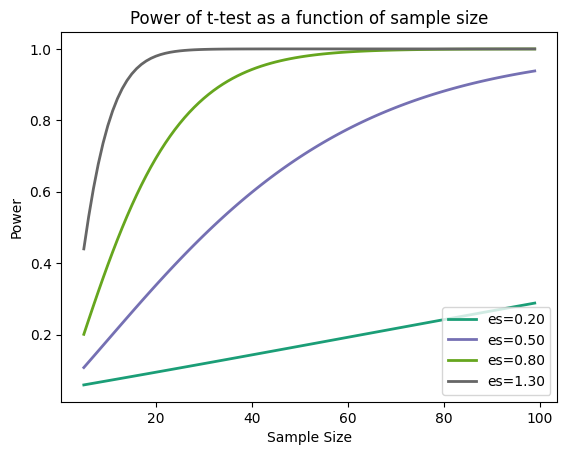

In [28]:
effect_size = 0.7  # Large effect size for demonstration
alpha = 0.05  # Significance level
power = 0.91  # Desired power

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
print(f"Required sample size: {sample_size:.2f}")

# creating a power plot
effect_sizes = np.array([0.2, 0.5, 0.8, 1.3])
sample_sizes = np.array(range(5, 100))

obj = TTestIndPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.title('Power of t-test as a function of sample size')
plt.xlabel('Sample Size')
plt.ylabel('Power')

# Show the plot
plt.show()
